In [79]:
# Import required libraries and dependencies
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import os
import sqlite3
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.ensemble import RandomForestClassifier
%matplotlib inline
from sklearn.datasets import make_blobs
from sklearn.svm import SVC 
import pickle
import joblib
import csv
import tensorflow as tf
import seaborn as sns
import warnings
from keras.models import load_model, save_model
from kerastuner.tuners import RandomSearch

In [80]:
# Suppress all warnings
warnings.filterwarnings("ignore")

# Dataset Description
* Age : Age of the patient
* Sex : Sex of the patient
    - 1 = male
    - 0 = female
* cp : Chest Pain type
    - Value 0: typical angina
    - Value 1: atypical angina
    - Value 2: non-anginal pain
    - Value 3: asymptomatic
* trtbps : resting blood pressure (in mm Hg)
* chol: cholesterol in mg/dl fetched via BMI sensor
* fbs: (fasting blood sugar > 120 mg/dl)
    - 1 = true
    - 0 = false
* rest_ecg: resting electrocardiographic results
    - Value 0: normal
    - Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
* thalach: maximum heart rate achieved
* exang: exercise induced angina
    - 1 = yes
    - 0 = no
* old peak: ST depression induced by exercise relative to rest
* slp: the slope of the peak exercise ST segment
    - 0 = unsloping
    - 1 = flat
    - 2 = downsloping
* caa: number of major vessels (0-3)
* thall : thalassemia
    - 0 = null
    - 1 = fixed defect
    - 2 = normal
    - 3 = reversable defect
* output: diagnosis of heart disease (angiographic disease status)
    - 0: < 50% diameter narrowing. less chance of heart disease
    - 1: > 50% diameter narrowing. more chance of heart disease

# Ron Briggs Analysis

In [81]:
# Load the data into a Pandas DataFrame
df_heartattack = pd.read_csv(
    "Data_csv/heart.csv")

# Display sample data
df_heartattack.head(10)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


In [82]:
# Generate summary statistics
df_heartattack.describe()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [83]:
# Plot your data to see what's in your DataFrame
df_heartattack.hvplot.line(
    width=800,
    height=400,
    rot=90
)

:NdOverlay   [Variable]
   :Curve   [index]   (value)

---

### Prepare the Data

In [84]:
# Use the `StandardScaler()` module from scikit-learn to normalize the data from the CSV file
scaler = StandardScaler()

In [85]:
# Create a DataFrame with the scaled data
scaled_data = scaler.fit_transform(df_heartattack)

# Copy the crypto names from the original data
crypto_names = df_heartattack.index
# Set the coinid column as index
df_scaled_heartattack = pd.DataFrame(scaled_data, columns=df_heartattack.columns, index=crypto_names)

# Display sample data
df_scaled_heartattack.head(10)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,0.952197,0.681005,1.973123,0.763956,-0.256334,2.394438,-1.005832,0.015443,-0.696631,1.087338,-2.274579,-0.714429,-2.148873,0.914529
1,-1.915313,0.681005,1.002577,-0.092738,0.072199,-0.417635,0.898962,1.633471,-0.696631,2.122573,-2.274579,-0.714429,-0.512922,0.914529
2,-1.474158,-1.468418,0.032031,-0.092738,-0.816773,-0.417635,-1.005832,0.977514,-0.696631,0.310912,0.976352,-0.714429,-0.512922,0.914529
3,0.180175,0.681005,0.032031,-0.663867,-0.198357,-0.417635,0.898962,1.239897,-0.696631,-0.206705,0.976352,-0.714429,-0.512922,0.914529
4,0.290464,-1.468418,-0.938515,-0.663867,2.082050,-0.417635,0.898962,0.583939,1.435481,-0.379244,0.976352,-0.714429,-0.512922,0.914529
5,0.290464,0.681005,-0.938515,0.478391,-1.048678,-0.417635,0.898962,-0.072018,-0.696631,-0.551783,-0.649113,-0.714429,-2.148873,0.914529
6,0.180175,-1.468418,0.032031,0.478391,0.922521,-0.417635,-1.005832,0.146634,-0.696631,0.224643,-0.649113,-0.714429,-0.512922,0.914529
7,-1.143291,0.681005,0.032031,-0.663867,0.323431,-0.417635,0.898962,1.021244,-0.696631,-0.896862,0.976352,-0.714429,1.123029,0.914529
8,-0.260980,0.681005,1.002577,2.306004,-0.913400,2.394438,0.898962,0.540209,-0.696631,-0.465514,0.976352,-0.714429,1.123029,0.914529
9,0.290464,0.681005,1.002577,1.049520,-1.512490,-0.417635,0.898962,1.064975,-0.696631,0.483451,0.976352,-0.714429,-0.512922,0.914529


---

### Find the Best Value for k Using the Original Data.

In [86]:
# Create a list with the number of k-values from 1 to 11
inertia = []

In [87]:
# Create an empty list to store the inertia values
k = list(range(1, 11))

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_market_data_scaled`
# 3. Append the model.inertia_ to the inertia list
for i in k:
    k_model = KMeans(n_clusters=i, random_state=1)
    k_model.fit(df_scaled_heartattack)
    inertia.append(k_model.inertia_)

In [88]:
# Create a dictionary with the data to plot the Elbow curve
elbow_data = {"k": k, "inertia": inertia}

# Create a DataFrame with the data to plot the Elbow curve
df_elbow = pd.DataFrame(elbow_data)

In [89]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_curve=df_elbow.hvplot.line(
    x="k", 
    y="inertia", 
    title="Elbow Curve", 
    xticks=k
)

plt.savefig('Visuals/elbow_curve.png')
elbow_curve

:Curve   [k]   (inertia)

<Figure size 640x480 with 0 Axes>

#### Answer the following question: 

**Question:** What is the best value for `k`?

**Answer:** 2 - this point has the sharpest bend

---

### Cluster Cryptocurrencies with K-means Using the Original Data

In [90]:
# Initialize the K-Means model using the best value for k
model = KMeans(n_clusters=2, random_state=1)

In [91]:
# Fit the K-Means model using the scaled data
model.fit(df_scaled_heartattack)

KMeans(n_clusters=2, random_state=1)

In [92]:
# Predict the clusters to group the cryptocurrencies using the scaled data
cluster_labels = model.predict(df_scaled_heartattack)

# Print the resulting array of cluster values.
print(cluster_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 1 0 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0]


In [93]:
# Create a copy of the DataFrame
cluster_label_predictions_df = df_scaled_heartattack.copy()

In [94]:
# Add a new column to the DataFrame with the predicted clusters
cluster_label_predictions_df['predicted cluster'] = cluster_labels

# Display sample data
cluster_label_predictions_df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output,predicted cluster
0,0.952197,0.681005,1.973123,0.763956,-0.256334,2.394438,-1.005832,0.015443,-0.696631,1.087338,-2.274579,-0.714429,-2.148873,0.914529,0
1,-1.915313,0.681005,1.002577,-0.092738,0.072199,-0.417635,0.898962,1.633471,-0.696631,2.122573,-2.274579,-0.714429,-0.512922,0.914529,0
2,-1.474158,-1.468418,0.032031,-0.092738,-0.816773,-0.417635,-1.005832,0.977514,-0.696631,0.310912,0.976352,-0.714429,-0.512922,0.914529,0
3,0.180175,0.681005,0.032031,-0.663867,-0.198357,-0.417635,0.898962,1.239897,-0.696631,-0.206705,0.976352,-0.714429,-0.512922,0.914529,0
4,0.290464,-1.468418,-0.938515,-0.663867,2.082050,-0.417635,0.898962,0.583939,1.435481,-0.379244,0.976352,-0.714429,-0.512922,0.914529,0


In [95]:
# Create a scatter plot using hvPlot by setting 
# `x="price_change_percentage_24h"` and `y="price_change_percentage_7d"`. 
# Color the graph points with the labels found using K-Means and 
# add the crypto name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.

cluster_label_predictions=cluster_label_predictions_df.hvplot.scatter(
    x="age",
    y="chol",
    c="predicted cluster",  # Color by the predicted clusters
    cmap=["orange", "red", "blue", "green"],  
    title="Heart Attack Clusters",
    xlabel="Age",
    ylabel="Chol",
    hover_cols=["predicted cluster", "coin_id"],  # Display predicted cluster and coin_id on hover
)

plt.savefig("Visuals/cluster_label_predictions.png")
cluster_label_predictions

:Scatter   [age]   (chol,predicted cluster)

<Figure size 640x480 with 0 Axes>

---

### Optimize Clusters with Principal Component Analysis.

In [96]:
# Create a PCA model instance and set `n_components=6`.
pca = PCA(n_components=6)

In [97]:
# Use the PCA model with fit_transform to reduce to six principal components.
pca_data = pca.fit_transform(df_scaled_heartattack)
df_pca = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], index=df_scaled_heartattack.index)

# View the first five rows of the DataFrame.
print(df_pca.head())


        PC1       PC2       PC3       PC4       PC5       PC6
0 -0.051739  2.624022  0.990054  3.479328  0.362773  1.695836
1 -0.817441 -0.730375 -0.235928  2.767545  2.258404 -0.808414
2 -2.057599 -0.039098 -0.519839  0.081198  0.860416  0.752783
3 -1.903043 -0.596701  0.076204 -0.082624 -0.235141 -0.500292
4 -0.768371  0.412545 -2.187455 -1.988510  0.017448 -0.074219


In [98]:
# Retrieve the explained variance to determine how much information 
# can be attributed to each principal component.
explained_variance = pca.explained_variance_ratio_
print("Explained Variance Ratios:", explained_variance)

Explained Variance Ratios: [0.23581966 0.11229748 0.08800207 0.08618849 0.07300207 0.06929774]


#### Answer the following question: 

**Question:** What is the total explained variance of the three principal components?

**Answer:** 0.435 - 3 components
            0.663 - 6 components

In [99]:
# Create a new DataFrame with the PCA data
df_pca_data = pd.DataFrame(data=pca_data, columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'], index=df_scaled_heartattack.index)

# Copy the crypto names from the original data
crypto_names = df_heartattack.index

# Set the '***' column as the index
#df_pca_data.index.name = '***'

# Display sample data
df_pca_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6
0,-0.051739,2.624022,0.990054,3.479328,0.362773,1.695836
1,-0.817441,-0.730375,-0.235928,2.767545,2.258404,-0.808414
2,-2.057599,-0.039098,-0.519839,0.081198,0.860416,0.752783
3,-1.903043,-0.596701,0.076204,-0.082624,-0.235141,-0.500292
4,-0.768371,0.412545,-2.187455,-1.988510,0.017448,-0.074219


---

### Find the Best Value for k Using the PCA Data

In [100]:
# Create a list with the number of k-values from 1 to 11
inertia_pca = []

In [101]:
# Create an empty list to store the inertia values
k_pca = list(range(1, 11))

# Create a for loop to compute the inertia with each possible value of k
# Inside the loop:
# 1. Create a KMeans model using the loop counter for the n_clusters
# 2. Fit the model to the data using `df_market_data_pca`
# 3. Append the model.inertia_ to the inertia list
for i in k_pca:
    k_model_pca = KMeans(n_clusters=i, random_state=1)
    k_model_pca.fit(df_pca_data)  # Use the PCA-transformed data
    inertia_pca.append(k_model_pca.inertia_)

In [102]:
# Create a dictionary with the data to plot the Elbow curve
elbow_data_pca = {"k": k_pca, "inertia": inertia_pca}

# Create a DataFrame with the data to plot the Elbow curve
df_elbow_pca = pd.DataFrame(elbow_data_pca)

In [103]:
# Plot a line chart with all the inertia values computed with 
# the different values of k to visually identify the optimal value for k.
elbow_curve_k_means=df_elbow_pca.hvplot.line(
    x='k',
    y='inertia',
    title='Elbow Curve for K-Means (PCA Data)',
    xlabel='Number of Clusters (k)',
    ylabel='Inertia',
    grid=True,
    height=400,
    width=600,
    line_color='blue',
)

plt.savefig("Visuals/elbow_curve_k_means.png")
elbow_curve_k_means

:Curve   [k]   (inertia)

<Figure size 640x480 with 0 Axes>

#### Answer the following questions: 

* **Question:** What is the best value for `k` when using the PCA data?

  * **Answer:** 2


* **Question:** Does it differ from the best k value found using the original data?

  * **Answer:** No

### Cluster Cryptocurrencies with K-means Using the PCA Data

In [104]:
# Initialize the K-Means model using the best value for k
model_pca = KMeans(n_clusters=2, random_state=1)

In [105]:
# Fit the K-Means model using the PCA data
model_pca.fit(df_pca_data)

KMeans(n_clusters=2, random_state=1)

In [106]:
# Predict the clusters to group the cryptocurrencies using the PCA data
cluster_labels_pca = model_pca.predict(df_pca_data)
# Print the resulting array of cluster values.
print(cluster_labels_pca)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 1
 0 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1
 1 1 0 1 1 1 1 1 0 1 1 1 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 0 0 1 1 1 1 1 1 1 1
 1 1 1 0 1 1 0]


In [107]:
# Create a copy of the DataFrame with the PCA data
cluster_label_predictions_pca_df = df_pca_data.copy()

# Add a new column to the DataFrame with the predicted clusters
cluster_label_predictions_pca_df['predicted cluster'] = cluster_labels_pca

# Display sample data
print(cluster_label_predictions_pca_df.head())

        PC1       PC2       PC3       PC4       PC5       PC6  \
0 -0.051739  2.624022  0.990054  3.479328  0.362773  1.695836   
1 -0.817441 -0.730375 -0.235928  2.767545  2.258404 -0.808414   
2 -2.057599 -0.039098 -0.519839  0.081198  0.860416  0.752783   
3 -1.903043 -0.596701  0.076204 -0.082624 -0.235141 -0.500292   
4 -0.768371  0.412545 -2.187455 -1.988510  0.017448 -0.074219   

   predicted cluster  
0                  0  
1                  0  
2                  0  
3                  0  
4                  0  


In [108]:
# Create a scatter plot using hvPlot by setting 
# `x="PC1"` and `y="PC2"`. 
# Color the graph points with the labels found using K-Means and 
# add the crypto name in the `hover_cols` parameter to identify 
# the cryptocurrency represented by each data point.

cluster_label_predictions_pca=cluster_label_predictions_pca_df.hvplot.scatter(
    x="PC1",
    y="PC2",
    c="predicted cluster",  # Color by the predicted clusters
    cmap=["orange", "red", "blue", "green"],  
    title="Clusters (PCA Data)",
    xlabel="Principal Component 1 (PC1)",
    ylabel="Principal Component 2 (PC2)",
    hover_cols=["predicted cluster"],  # Display predicted cluster and coin_id on hover
    width=600,
    height=400,
)

plt.savefig("Visuals/cluster_label_predictions_pca.png")
cluster_label_predictions_pca

:Scatter   [PC1]   (PC2,predicted cluster)

<Figure size 640x480 with 0 Axes>

### Visualize and Compare the Results

In this section, you will visually analyze the cluster analysis results by contrasting the outcome with and without using the optimization techniques.

In [109]:
# Composite plot to contrast the Elbow curves
composite_plot = df_elbow + df_elbow_pca
composite_plot

,k,inertia
0,2,7061.265143
1,4,5552.507151
2,6,5062.744517
3,8,4700.974311
4,10,4423.832434
5,12,4210.512233
6,14,4011.777811
7,16,3900.050811
8,18,3762.649718
9,20,3624.778276


In [110]:
composite_plt=composite_plot.hvplot.line(
    x='k',
    y='inertia',
    title='Composite Plot',
    xlabel='Number of Clusters (k)',
    ylabel='Inertia',
    grid=True,
    height=400,
    width=600,
    line_color='blue',
)
composite_plt
plt.savefig("Visuals/composite_plt.png")
composite_plt

:Curve   [k]   (inertia)

<Figure size 640x480 with 0 Axes>

In [111]:
# Create a composite plot to contrast the clusters of the original data and the PCA data

composite_plot2 = cluster_label_predictions_df.hvplot.scatter(
    x="sex",
    y="chol",
    c="predicted cluster",  # Color by the predicted clusters of the original data
    cmap=["orange", "red", "blue", "green"],
    title="Clusters (Original Data)",
    xlabel="sex",
    ylabel="chol",
    hover_cols=["predicted cluster", "coin_id"],  # Display predicted cluster and coin_id on hover
    width=600,
    height=400,
) + cluster_label_predictions_pca_df.hvplot.scatter(
    x="PC1",
    y="PC2",
    c="predicted cluster",  # Color by the predicted clusters of the PCA data
    cmap=["orange", "red", "blue", "green"],
    title="Clusters (PCA Data)",
    xlabel="Principal Component 1 (PC1)",
    ylabel="Principal Component 2 (PC2)",
    hover_cols=["predicted cluster", "coin_id"],  # Display predicted cluster and coin_id on hover
    width=600,
    height=400,
)

# Show the composite plot
composite_plot2
plt.savefig("Visuals/composite_plot2.png")
composite_plot2

:Layout
   .Scatter.I  :Scatter   [sex]   (chol,predicted cluster)
   .Scatter.II :Scatter   [PC1]   (PC2,predicted cluster)

<Figure size 640x480 with 0 Axes>

#### Answer the following question: 

  * **Question:** After visually analyzing the cluster analysis results, what is the impact of using fewer features to cluster the data using K-Means?

  * **Answer:** The resulting cluster is smaller and more concentrated. The outliers are more distinct and there is less noise. The trade-offs include a loss of data and the choice of PCA components are subjective.

# Dhawanpreet's Logistic Regression Model

In [112]:
csv_file_path ="Data_csv/heart.csv"

In [113]:
def create_sqlite_database(csv_file_path, db_file_path, table_name):
    # Read data from the CSV file using pandas
    df = pd.read_csv(csv_file_path)

    # Connect to the SQLite database or create a new one if it doesn't exist
    conn = sqlite3.connect(db_file_path)

    # Write the DataFrame to the SQLite database as a new table
    df.to_sql(table_name, conn, if_exists='replace', index=False)

    # Close the connection
    conn.close()

if __name__ == "__main__":
    # Get the absolute path of the current directory and the Resources directory
    current_dir = os.path.dirname(os.path.abspath(__name__))
    resources_dir = os.path.join(current_dir, "Data_csv") #path where your file is

    # File paths for CSV and SQLite database
    csv_file_path = os.path.join(resources_dir, "heart.csv") # file name which you want to read 
    db_file_path = os.path.join(current_dir, "Heart.sqlite") # file name give it which you are creating
    table_name = "table1" # name of the table 

    create_sqlite_database(csv_file_path, db_file_path, table_name)

In [114]:
#Establish connection to SQLite Database

conn = sqlite3.connect(db_file_path)

query = "SELECT * FROM table1"

# cursor.execute(query)
# rows = cursor.fetchall()
# for row in rows:
#     print(row)

# Read data from the database and store it in a DataFrame
heart_df = pd.read_sql_query(query, conn)
heart_df.head()

conn.close()


In [115]:
heart_df

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


In [116]:
# checking if the data is balanced or not
heart_df.output.value_counts()

output
1    165
0    138
Name: count, dtype: int64

In [117]:
# Split the data into X (features) and y (target)
# The y variable should focus on the target column
y = heart_df['output']

# The X variable should include all features except the target
X = heart_df.drop(columns=['output'])


In [118]:

# Split the data using train_test_split
# Assign a random_state of 1 to the function
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=1 ,stratify=y)

In [119]:

# Instantiate the Logistic Regression model
# Assign a random_state parameter of 1 to the model
logistic_regression_model = LogisticRegression(random_state=1)

# Fit and save the logistic regression model using the training data
lr_model = logistic_regression_model.fit(X_train, y_train)

In [120]:
# Make a prediction using the testing data
testing_predictions = logistic_regression_model.predict(X_test)

In [121]:
# Print the balanced_accuracy score of the model
balanced_accuracy_score_of_model =balanced_accuracy_score(y_test,testing_predictions)
balanced_accuracy_score_of_model

0.851219512195122

In [122]:
# Generate a confusion matrix for the model
testing_matrix = confusion_matrix(y_test,testing_predictions)

# Print the confusion matrix for the training data
print(testing_matrix)

[[28  7]
 [ 4 37]]


In [123]:
# Print the classification report for the model
logistic_report = classification_report(y_test, testing_predictions)
print(logistic_report)

              precision    recall  f1-score   support

           0       0.88      0.80      0.84        35
           1       0.84      0.90      0.87        41

    accuracy                           0.86        76
   macro avg       0.86      0.85      0.85        76
weighted avg       0.86      0.86      0.85        76



In [124]:
joblib.dump(logistic_regression_model,"Models/dd.h5")

['Models/dd.h5']

# Leif's Random Forest Classifier Model

In [125]:
#Checking the balance
df_heartattack["output"].value_counts()

output
1    165
0    138
Name: count, dtype: int64

In [126]:
# Define features set
X = df_heartattack.copy()
X.drop("output", axis=1, inplace=True)

In [127]:
# Define target vector
y = df_heartattack["output"]

In [128]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=78)

In [129]:
# Creating StandardScaler instance; Fitting Standard Scaler; Scaling the data
scaler = StandardScaler()

X_scaler = scaler.fit(X_train)

X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [130]:
# Create a random forest classifier; Fit the model; Make predictions using the testing data
rf_model = RandomForestClassifier(n_estimators=500, random_state=78)

rf_model = rf_model.fit(X_train_scaled, y_train)
 
predictions = rf_model.predict(X_test_scaled)

In [131]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [132]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,27,12
Actual 1,3,34


Accuracy Score : 0.8026315789473685
Classification Report
              precision    recall  f1-score   support

           0       0.90      0.69      0.78        39
           1       0.74      0.92      0.82        37

    accuracy                           0.80        76
   macro avg       0.82      0.81      0.80        76
weighted avg       0.82      0.80      0.80        76



In [133]:
joblib.dump(rf_model,"Models/lm_model.h5")

['Models/lm_model.h5']

# Huma's SVC Model
- Likelihood of Heartattack Model Prediction Training with SVC Linear

In [134]:
# Get the target variables, here it is the liklihood of an heartattack, which is
# decribed in column, "output" 
y = heart_df["output"]
class_names = ["No Heart Disease", "Heart Disease"]

In [135]:
# Get the features, by dropping the target from the original dataframe 
X = heart_df.drop("output", axis=1)
feature_names = X.columns

In [136]:
# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

SVC Linear Model Setup and Training

In [137]:
# Support vector machine linear classifier

model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

In [138]:
# Model Accuracy
print('Test Acc: %.3f' % model.score(X_test, y_test))

Test Acc: 0.868


In [139]:
# Calculate the classification report
predictions = model.predict(X_test)
report = classification_report(y_test, predictions, target_names=class_names)
print(report)

                  precision    recall  f1-score   support

No Heart Disease       0.88      0.83      0.85        35
   Heart Disease       0.86      0.90      0.88        41

        accuracy                           0.87        76
       macro avg       0.87      0.87      0.87        76
    weighted avg       0.87      0.87      0.87        76



Make Predictions

In [140]:
# Compare the Predicted and Actual Values of the Model 
actual_data_predicted = pd.DataFrame({"Prediction": predictions, "Actual": y_test})

actual_data_predicted.head(25)

,Prediction,Actual
179,0,0
228,1,0
111,1,1
246,0,0
60,1,1
9,1,1
119,1,1
223,0,0
268,0,0
33,1,1


In [141]:
print('Test Acc: %.3f' % model.score(X_test, y_test))

print(report)

Test Acc: 0.868
                  precision    recall  f1-score   support

No Heart Disease       0.88      0.83      0.85        35
   Heart Disease       0.86      0.90      0.88        41

        accuracy                           0.87        76
       macro avg       0.87      0.87      0.87        76
    weighted avg       0.87      0.87      0.87        76



Save Trained Model in Pickle format ready for Deploment

In [142]:

filename = 'Models/svc_finalized_model.pkl'
pickle.dump(model, open(filename, 'wb'))


In [143]:
# Without configuration
model.opimizer=None
model.compiled_loss= None
model.compiled_metrics = None
joblib.dump(model,"Models/final_prediction_model.h5")

['Models/final_prediction_model.h5']

Load Trained Model

In [144]:
# load the Svc linear trained model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.868421052631579


# Deepika's Neural Network Model

In [145]:
corr=heart_df.corr()
corr

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
age,1.000000,-0.098447,-0.068653,0.279351,0.213678,0.121308,-0.116211,-0.398522,0.096801,0.210013,-0.168814,0.276326,0.068001,-0.225439
sex,-0.098447,1.000000,-0.049353,-0.056769,-0.197912,0.045032,-0.058196,-0.044020,0.141664,0.096093,-0.030711,0.118261,0.210041,-0.280937
cp,-0.068653,-0.049353,1.000000,0.047608,-0.076904,0.094444,0.044421,0.295762,-0.394280,-0.149230,0.119717,-0.181053,-0.161736,0.433798
trtbps,0.279351,-0.056769,0.047608,1.000000,0.123174,0.177531,-0.114103,-0.046698,0.067616,0.193216,-0.121475,0.101389,0.062210,-0.144931
chol,0.213678,-0.197912,-0.076904,0.123174,1.000000,0.013294,-0.151040,-0.009940,0.067023,0.053952,-0.004038,0.070511,0.098803,-0.085239
fbs,0.121308,0.045032,0.094444,0.177531,0.013294,1.000000,-0.084189,-0.008567,0.025665,0.005747,-0.059894,0.137979,-0.032019,-0.028046
restecg,-0.116211,-0.058196,0.044421,-0.114103,-0.151040,-0.084189,1.000000,0.044123,-0.070733,-0.058770,0.093045,-0.072042,-0.011981,0.137230
thalachh,-0.398522,-0.044020,0.295762,-0.046698,-0.009940,-0.008567,0.044123,1.000000,-0.378812,-0.344187,0.386784,-0.213177,-0.096439,0.421741
exng,0.096801,0.141664,-0.394280,0.067616,0.067023,0.025665,-0.070733,-0.378812,1.000000,0.288223,-0.257748,0.115739,0.206754,-0.436757
oldpeak,0.210013,0.096093,-0.149230,0.193216,0.053952,0.005747,-0.058770,-0.344187,0.288223,1.000000,-0.577537,0.222682,0.210244,-0.430696


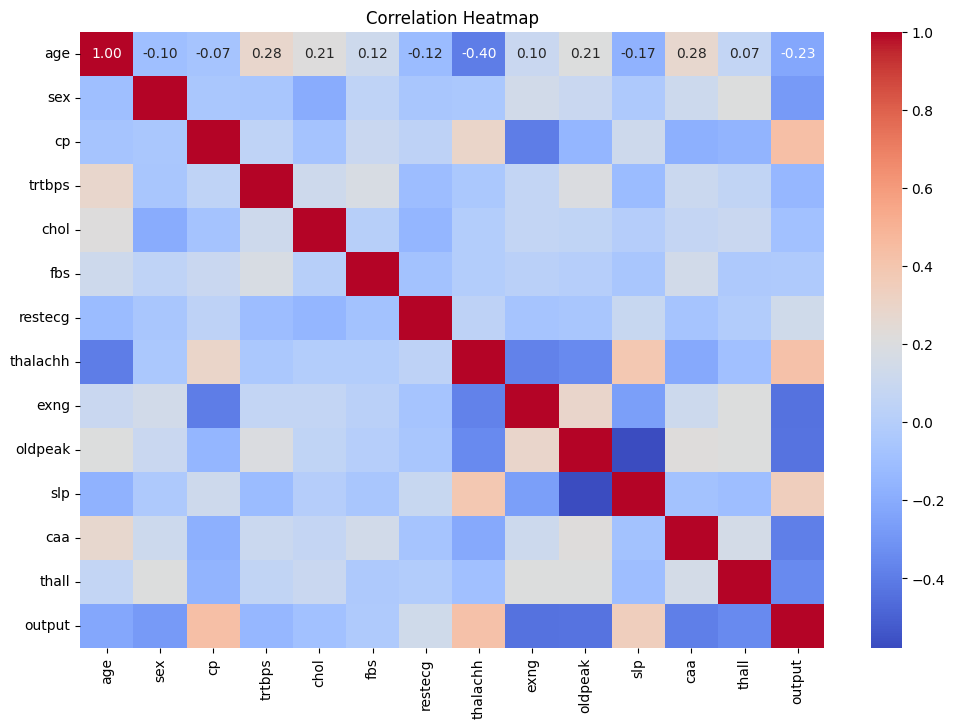

<Figure size 640x480 with 0 Axes>

In [146]:
# Correlation Heatmap between the features
corr_matrix = heart_df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()
plt.savefig("Visuals/corr_matrix.png")

## Correlation Anaylsis
- Age and Maximum Heart Rate (thalachh): Negative correlation (-0.40) indicates that as age increases, maximum heart rate tends to decrease.
- Sex and Heart Disease (output): Negative correlation (-0.28) suggests that females may have a lower likelihood of heart disease compared to males.
- Chest Pain Type (cp) and Heart Disease (output): Positive correlation (0.43) suggests that certain chest pain types may be associated with a higher likelihood of heart disease.
- Age and Resting Blood Pressure (trtbps): Positive correlation (0.28) implies that as age increases, resting blood pressure tends to increase.
- Age and Number of Major Vessels (caa): Positive correlation (0.28) indicates that older individuals may have more major vessels with potential blockages.
- Maximum Heart Rate (thalachh) and Heart Disease (output): Positive correlation (0.42) suggests that a higher maximum heart rate may be linked to heart disease.
- Exercise-Induced Angina (exng) and Heart Disease (output): Negative correlation (-0.44) implies that angina during exercise may be associated with a lower likelihood of heart disease.
- ST Depression (oldpeak) and Number of Major Vessels (caa): Strong negative correlation (-0.58) suggests that as ST depression increases, the number of major vessels tends to decrease.
- Number of Vessels (caa) and Thallium Stress Test (thall): Negative correlation (-0.39) indicates that as the number of major vessels increases, thallium stress test results tend to decrease.
- Chest Pain Type (cp) and Slope of the ST Segment (slp): Positive correlation (0.35) suggests a potential relationship between chest pain type and the slope of the ST segment.

In [147]:
# Remove output from features data
y = heart_df.output.values
X = heart_df.drop(columns="output").values

# Split training/test datasets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [148]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(ha):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = ha.Choice('activation',['relu','tanh','sigmoid'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=ha.Int('first_units',
        min_value=1,
        max_value=64,
        step=2), activation=activation, input_dim=13))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(ha.Int('num_layers', 1, 6)):
        nn_model.add(tf.keras.layers.Dense(units=ha.Int('units_' + str(i),
            min_value=1,
            max_value=64,
            step=2),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [149]:

tuner = RandomSearch(
    create_model,
    objective='val_accuracy',
    max_trials=100,
    directory=None, 
    project_name=None,  
)

In [150]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train, y_train, validation_data=(X_test_scaled, y_test))

Trial 100 Complete [00h 00m 01s]
val_accuracy: 0.5394737124443054

Best val_accuracy So Far: 0.6315789222717285
Total elapsed time: 00h 02m 54s
INFO:tensorflow:Oracle triggered exit


In [151]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'relu',
 'first_units': 61,
 'num_layers': 5,
 'units_0': 7,
 'units_1': 5,
 'units_2': 7,
 'units_3': 53,
 'units_4': 19,
 'units_5': 3}

In [152]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

3/3 - 0s - loss: 0.6867 - accuracy: 0.6316 - 183ms/epoch - 61ms/step
Loss: 0.6867321133613586, Accuracy: 0.6315789222717285


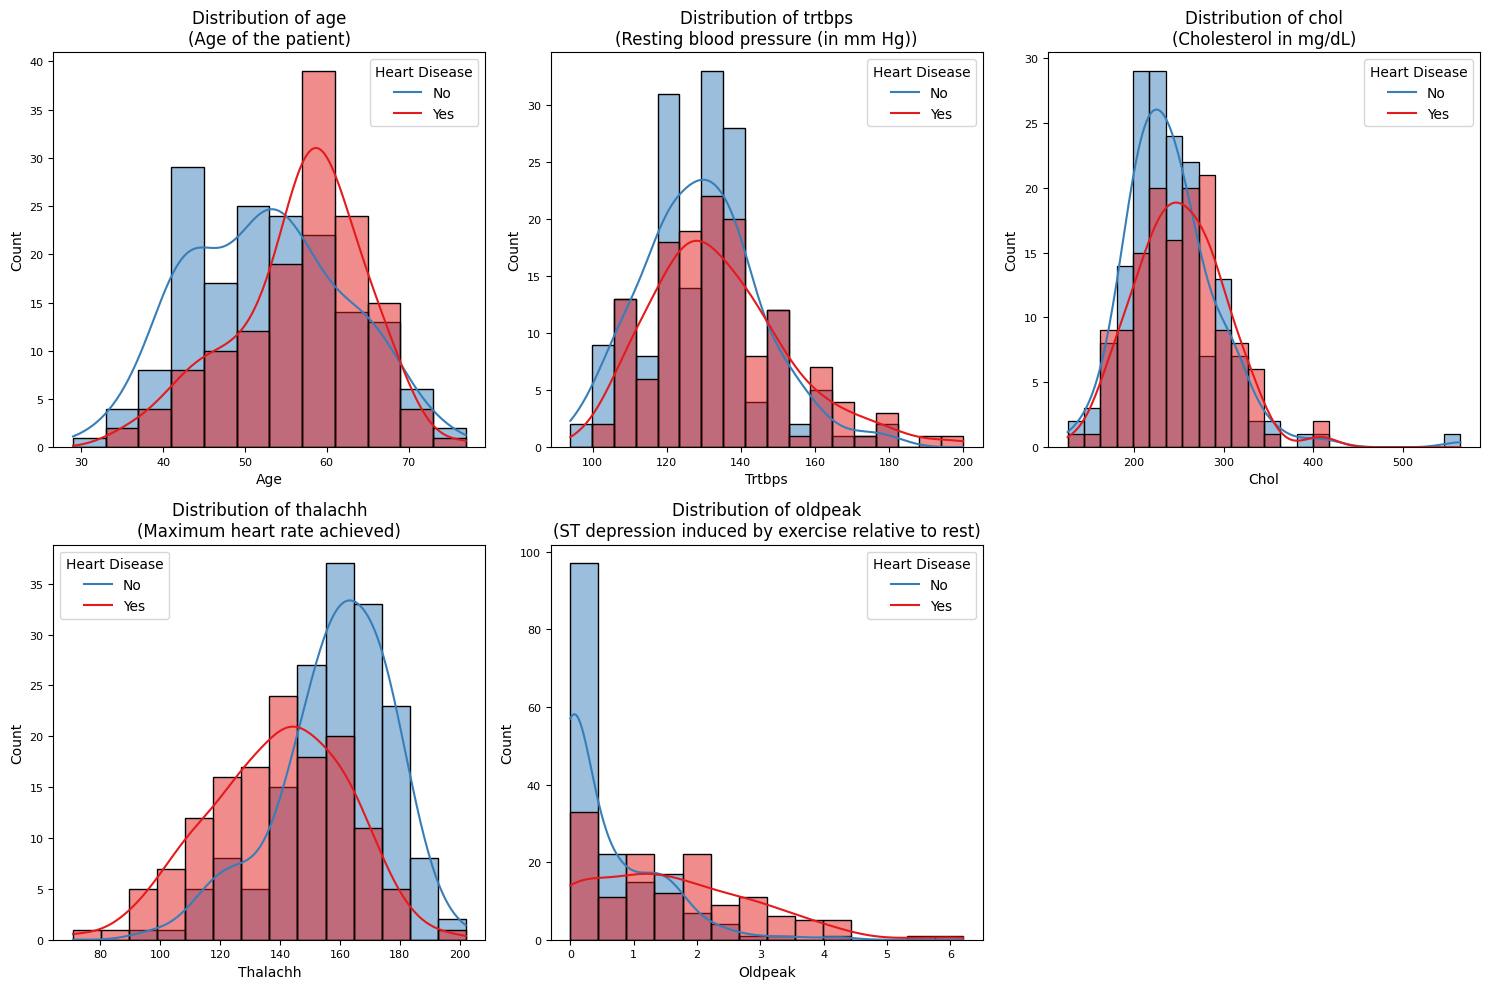

In [153]:

# Define numeric variables
numeric_variables = ["age", "trtbps", "chol", "thalachh", "oldpeak"]

# Create a dictionary of variable explanations
variable_explanations = {
    "age": "Age of the patient",
    "trtbps": "Resting blood pressure (in mm Hg)",
    "chol": "Cholesterol in mg/dL",
    "thalachh": "Maximum heart rate achieved",
    "oldpeak": "ST depression induced by exercise relative to rest"
}

# Create distribution plots with variable explanations
plt.figure(figsize=(15, 10))
for i, var in enumerate(numeric_variables, 1):
    plt.subplot(2, 3, i)
    
    # Plot the distribution using a histogram and KDE
    sns.histplot(data=heart_df, x=var, hue="output", kde=True, palette="Set1")
    
    # Add variable explanation for context
    plt.title(f"Distribution of {var}\n({variable_explanations[var]})", fontsize=12)
    plt.xlabel(var.capitalize(), fontsize=10)
    plt.ylabel("Count", fontsize=10)
    
    # Add legend for heart disease status
    plt.legend(title="Heart Disease", labels=["No", "Yes"], title_fontsize=10)
    
    # Customize tick labels and font size
    plt.xticks(fontsize=8)
    plt.yticks(fontsize=8)

# Adjust spacing between subplots
plt.tight_layout()
plt.savefig('Visuals/Distribution_plot.png',)

# Show the plots
plt.show()



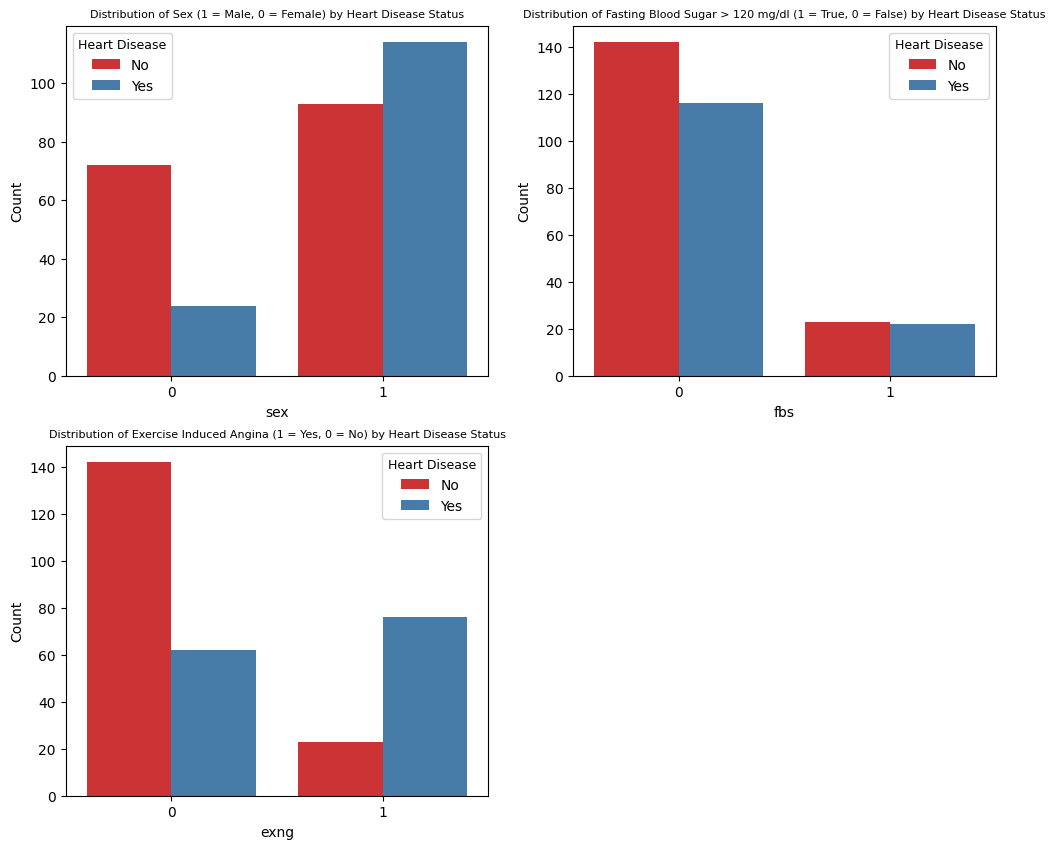

In [154]:
# Define a custom color palette for your plots
custom_palette = sns.color_palette("Set1")
# Convert the "output" column to a categorical data type
heart_df["output"] = heart_df["output"].astype(str)

# Define binary variables and their descriptions
binary_variables = {
    "sex": "Sex (1 = Male, 0 = Female)",
    "fbs": "Fasting Blood Sugar > 120 mg/dl (1 = True, 0 = False)",
    "exng": "Exercise Induced Angina (1 = Yes, 0 = No)"
}

# Create countplots for binary variables with added style
plt.figure(figsize=(12, 10))

# Specify grid dimensions based on the number of binary variables
n_rows, n_cols = 2, 2

for i, (var, description) in enumerate(binary_variables.items(), 1):
    plt.subplot(n_rows, n_cols, i)
    
    # Create a countplot with hue (heart disease status) and a custom color palette
    sns.countplot(data=heart_df, x=var, hue="output", palette=custom_palette)
    
    # Customize labels and title
    plt.title(f"Distribution of {description} by Heart Disease Status", fontsize=8)
    plt.xlabel(var, fontsize=10)
    plt.ylabel("Count", fontsize=10)
    
    # Add a legend with labels
    plt.legend(title="Heart Disease", labels=["No", "Yes"], title_fontsize=9)
    
    # Customize tick labels and font size
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

# Adjust spacing between subplots
#plt.tight_layout()

# Save the countplot as an image
plt.savefig('Visuals/binary_countplot.png',)

# Show the plots (optional)
plt.show()

In [155]:
#save the model
best_model.save("Models/dp_model.h5")

In [156]:
from keras.models import load_model

model=load_model("Models/dp_model.h5")

input_values=(44,1,0,120,169,0,1,144,1,2.8,0,0,1)

#Change the input data to a numpy array from tuple

input_value_numpy=np.asarray(input_values)

#reshape the numpy array 

input_valuesz_reshaped=input_value_numpy.reshape(1,-1)

prediction=model.predict(input_valuesz_reshaped)



1/1 [==============================] - 0s 65ms/step
